# Gravity model, notes cited from professor Sobolevsky, NYU CUSP

### Results are shown at the end

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import time
import scipy.stats as stat
import statsmodels.formula.api as smf
from sklearn import linear_model
from geopy.distance import vincenty
%pylab inline
import warnings
warnings.filterwarnings('ignore')
RootPath = '/Users/CQ/Documents/Project1'

#plt.rcParams["figure.figsize"]=(20,15)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


It is a common property for many spatial networks to have edge weight decay with distance (connections between more distant objects are weaker). This dependence is often thought as a power-law trend:
$$
e(a,b)\sim d(a,b)^{-\gamma}.
$$

However often nodes are not equal - for example in case of human mobility networks, where nodes are locations in space, while edges represent number of people moving between them, nodes might be of different size or different density. In this case one could also consider
$$
e(a,b)\sim w(a),\ e(a,b)\sim w(b),
$$
or more generally (keeping an idea of the power-law dependence and assuming under-/super-linear scaling of destination attractiveness or origin activity with size): 
$$
e(a,b)\sim w(a)^\alpha,\ e(a,b)\sim w(b)^\beta.
$$
where $w(x)$ is the weight of the node $x$. 

## General model

All together those relations lead to a model
$$
e(a,b)=k\cdot w(a) w(b) d(a,b)^{-\gamma},
$$
or more generally
$$
e(a,b)=k\cdot w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma},
$$
where $k$ is the global proportionality (normalization) factor
$$
k=\frac{\sum\limits_{a,b}e(a,b)}{\sum\limits_{a,b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

In case network does not have loop edges to model, the normalization factor is defined as
$$
k=\frac{\sum\limits_{a\neq b}e(a,b)}{\sum\limits_{a\neq b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

Often it is reasonable to assume that $\alpha=\beta$ (especially if the network is symmetric, like representing number of people visiting both locations $a$ and $b$ regardless their order or cumulative communication flux between the two locations regardless directionality). 

This model is called gravity model.

## Gravity model with local normalization

Alternatively, one can also introduce local normalization, assuming relative scaling of strength of attractiveness of different destinations $b$ for the origin $a$ to be proportional to
$$
{\rm attr}_a(b)\sim w(b)^\beta d(a,b)^{-\gamma}.
$$
Given the known total outgoing strength $T(a)$ for each node $a$, this leads to the model
$$
e(a,b)=T(a) \frac{{\rm attr}_a(b)}{\sum_c {\rm attr}_a(c)}
$$
i.e.
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_c w(c)^\beta d(a,c)^{-\gamma}}.
$$
In case loop edges are missing in the network one should rather write
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_{c\neq a} w(c)^\beta d(a,c)^{-\gamma}},
$$
as the entire outgoing strenth is to be distributed among the possible non-loop edges for $c\neq a$. 

## Radiation model

Another alternative approach to modelling spatial networks of human mobility and potentially interactions has been suggested in a recent paper [Simini, F., González, M. C., Maritan, A., & Barabási, A. L. (2012). A universal model for mobility and migration patterns. Nature, 484(7392)]. The key idea is that people select a closet destination bettan than the one they have in their location of origin according to a certain attractiveness distribution and the beauty of the model is that it gives a one single paramter-free formulae (just based on the given population distribution, nothing to fit or assume unlike the exponents in the gravity model), no matter what the assumed attractiveness distribution was. The model however also relies on the knowledge of the cumulative outgoing strength of the nodes, just like the gravity model with the local normalization does.

The model predicting mobility flux (an edge) $e(a,b)$ between two locations $a,b$ is
$$
e(a,b)=T(a)\frac{p(a)p(b)}{\left(p(a)+s(a,b)\right)\left(p(a)+p(b)+s(a,b)\right)},
$$
where $p(a)$ denotes the population of the location $a$, while $s(a,b)$ is the total population enclosed in the circle centered in $a$ with the radius equal to $d(a,b)$ (i.e. the total population residing no further from $a$ compared to $b$).

In [2]:
twitter_file = pd.read_csv(RootPath + '/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv(RootPath + '/USzipcode_XY.csv')
twitter_file.columns = ['Date','Time','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']
twitter_file.Time = pd.to_datetime(twitter_file.Time, unit='s') - timedelta(hours=5) ## UTS - 5h NYC
twitter_file.Date = twitter_file.Time.dt.date

PLACES = USzipcode.ZipCode[USzipcode.ZipCode.isin(twitter_file.ZipCode.unique())]
PLACES.index = range(len(PLACES))

start_date = twitter_file.iloc[0,0]
end_date = twitter_file.iloc[-1,0]
day_count = (end_date-start_date).days + 1
DateList = [start_date + timedelta(n) for n in range(day_count)]

def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

Days = range(day_count)
for single_day in DateList:
    Days[DateList.index(single_day)] = twitter_file[twitter_file.Date == single_day]
    Days[DateList.index(single_day)] = Clean_zipcode(Days[DateList.index(single_day)])

In [4]:
#Net1Day, Net2Day = range(day_count), range(day_count)
Net1GravDegree, Net2GravDegree = range(day_count), range(day_count)
Net1GravPageRk, Net2GravPageRk = range(day_count), range(day_count)
for i in range(day_count):
#     Net1Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Naive/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)
#     Net2Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Prob/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)
    Net1GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Net1/DegCentrality/Day %d.csv'%(i+1), index_col=0)
    Net2GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Net2/DegCentrality/Day %d.csv'%(i+1), index_col=0)
    Net1GravPageRk[i] = pd.read_csv(RootPath +'/GravModel/TimeSeries/Net1/PgRCentrality/Day %d.csv'%(i+1), index_col=0)
    Net2GravPageRk[i] = pd.read_csv(RootPath +'/GravModel/TimeSeries/Net2/PgRCentrality/Day %d.csv'%(i+1), index_col=0)

def LMOutput(model_index = 1, net_index = 1, centrality_index = 1, plot_index = 1, plot_action = False):
    '''
    This function outputs all lm.summary of our data, and the input arguments are
    model_index:
    1--log(weight)~log(distance) & log(weight) ~ log(distance)+log(tweet1)+log(tweet2) with all data
    2--Same lm but split data into two parts, one for training, one for validation
    net_index:
    1--naive network
    2--probabilistic network
    centrality_index:
    1--degree
    2--page rank
    plot_index
    1--plot log(weight)~log(distance)
    2--plot log(weight) ~ log(distance)+log(tweet1)+log(tweet2)
    '''
    LM1, LM2 = range(day_count), range(day_count)
    for i in range(day_count):
        if centrality_index == 1:
            data = Net1GravDegree[i].iloc[:,2:] if net_index == 1 else Net2GravDegree[i].iloc[:,2:]
        else:
            data = Net1GravPageRk[i].iloc[:,2:] if net_index == 1 else Net2GravPageRk[i].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        if sum(missing_check) == 0:
            LM1[i], LM2[i] = False, False
        else:
            if model_index == 1:
                LM1[i] = smf.ols(formula='log(weight) ~ log(distance)', data = data).fit()
                LM2[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = data).fit()
            else:
                random.seed(2016)
                ind = stat.bernoulli.rvs(p = 0.75, size = len(data.weight))
                train = data.loc[ind == 1]
                valid = data.loc[ind == 0]
                LM1[i] = smf.ols(formula='log(weight) ~ log(distance)', data = train).fit()
                LM2[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = train).fit()
    index = [LM1.index(x) for x in LM1 if x]
    datelist = [DateList[i] for i in index]
    size = len(index)
    nrows = size/6 + ((size%6)!=0)
    ncols = 6    
    Title = 'Naive Network' if net_index ==1 else 'Probabilistic Network'
    if plot_action:
        fig = plt.figure(figsize=(20, 4*nrows))
        plt.suptitle(Title, fontweight="bold", size = 18)
    summary = []
    for i in range(size):
        if plot_action:
            plt.subplot(nrows, ncols, i+1)
        if centrality_index == 1:
            data = Net1GravDegree[index[i]].iloc[:,2:] if net_index == 1 else Net2GravDegree[index[i]].iloc[:,2:]
        else:
            data = Net1GravPageRk[index[i]].iloc[:,2:] if net_index == 1 else Net2GravPageRk[index[i]].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        lm1 = LM1[index[i]]
        lm2 = LM2[index[i]]
        if model_index == 1:
            lme = lm1.predict(data) if plot_index == 1 else lm2.predict(data)
            if plot_action:
                plt.plot(lme,log(data.weight),'or')
                plt.plot(lme,lme,'-b')
                plt.title(datelist[i], fontweight='bold')
            a = [lm1.rsquared, lm1.pvalues[1], lm1.params[1]]
            b = [lm2.rsquared, lm2.pvalues[1], lm2.params[1], lm2.params[2], lm2.params[3]]
            c = a+b
            summary.append(c)
        else:
            lme = lm1.predict(valid) if plot_index == 1 else lm2.predict(valid)
            R2=1-sum(pow(log(valid.weight)-lme,2))/sum(pow(log(valid.weight)-mean(log(valid.weight)),2))
            if plot_action:
                plt.plot(lme,log(valid.weight),'or')
                plt.plot(lme,lme,'-b')
                R2=1-sum(pow(log(valid.weight)-lme,2))/sum(pow(log(valid.weight)-mean(log(valid.weight)),2))
                plt.title(datelist[i].strftime("%Y-%m-%d")+'\nValidation error=%f'%R2, fontweight='bold')
            a = [lm1.rsquared, lm1.pvalues[1], lm1.params[1],R2]
            b = [lm2.rsquared, lm2.pvalues[1], lm2.params[1], lm2.params[2], lm2.params[3],R2]
            c = a+b
            summary.append(c)
    a = 3 if model_index == 1 else 4
    model1 = ['log(weight) ~ log(dist)']*a
    b = 5 if model_index == 1 else 6
    model2 = ['log(weight) ~ log(dist)+log(tweet1)+log(tweet2)']*b
    line_1 = model1 + model2
    line_2 = ['R squared','Dist_pvalues','Dist_Coef','R squared','Dist_pvalues','Dist_Coef','Tweet1_Coef',
              'Tweet2_Coef'] if model_index == 1 else ['R squared','Dist_pvalues','Dist_Coef','Validation Error',
              'R squared','Dist_pvalues','Dist_Coef','Tweet1_Coef','Tweet2_Coef','Validation Error']
    arrays = [line_1, line_2]
    tuples = list(zip(*arrays))
    column = pd.MultiIndex.from_tuples(tuples, names=['Model', 'Parameters'])
    #fig.tight_layout()
    plt.subplots_adjust(top=0.95, hspace = 0.25)
    return pd.DataFrame(summary, index = datelist, columns = column)

DegNaive1 = LMOutput(1,1,1)
DegNaive2 = LMOutput(2,1,1)
DegProb1 = LMOutput(1,2,1)
DegProb2 = LMOutput(2,2,1)
PgRNaive1 = LMOutput(1,1,2)
PgRNaive2 = LMOutput(2,1,2)
PgRProb1 = LMOutput(1,2,2)
PgRProb2 = LMOutput(2,2,2)

def ConstructLine(x):
    '''
    This function is to fill in all missing value with 0
    x here is the "partition" or "dict" or simply a two-column dataframe indicating the 
    relationship between dates and its value, e.g. R^2 or Dist_Coefficients
    '''
    return [(x.index[i],x.values[i]) for i in range(len(x))]

LINE = range(8)
LINE[0] = ConstructLine(DegNaive1.iloc[:,5])
LINE[1] = ConstructLine(DegNaive2.iloc[:,6])
LINE[2] = ConstructLine(DegProb1.iloc[:,5])
LINE[3] = ConstructLine(DegProb2.iloc[:,6])

LINE[4] = ConstructLine(PgRNaive1.iloc[:,5])
LINE[5] = ConstructLine(PgRNaive2.iloc[:,6])
LINE[6] = ConstructLine(PgRProb1.iloc[:,5])
LINE[7] = ConstructLine(PgRProb2.iloc[:,6])

def ExponentPlot():
    CENT = ['Degree','Page Rank']
    MODEL = ['log(weight)~log(distance)','log(weight)~log(distance)+log(tweet1)+log(tweet2)']
    NET = ['Naive','Probabilistic']
    plt.figure(figsize=(20,20))
    Color = matplotlib.cm.spectral(np.linspace(0,1,8))
    for i in range(8):
        plt.subplot(811+i)
        plt.plot(zip(*LINE[i])[0], zip(*LINE[i])[1],c=Color[i], lw=3)
        plt.title(NET[(i/2)%2]+' Network with '+CENT[i/4]+' Centrality, '+MODEL[i%2], size = 18)
    plt.subplots_adjust(hspace=0.4)

## Based on the value of $R^2$, our model needs some improvement if we want to use it to have better prediction of future data. However, if we only want to know whether the exponent of distance fluctuates over time, then the answer can be seen as follows:

## Below is the plot of exponent of DISTANCE, some notes:

### • For some days we don't have any data at all, and for those days we do, the majority of the users has only posted one single tweet, causing the graph having no "link" but only isolated "nodes", resulting in multiple days with value 0 as default, making the lines rather serrated than smooth. 
### • The general trend are pretty similar to each other, I guess it's because our model can't sufficiently demonstrate the variablity of the data ($R^2$ is somewhere between 0.05 to 0.4)
### • Despite the general trend, naive networks have much less variance than probabilistic networks if we take a closer look at the y-axis. The exponent in prob network is about 4 times large as its couterpart in naive network.

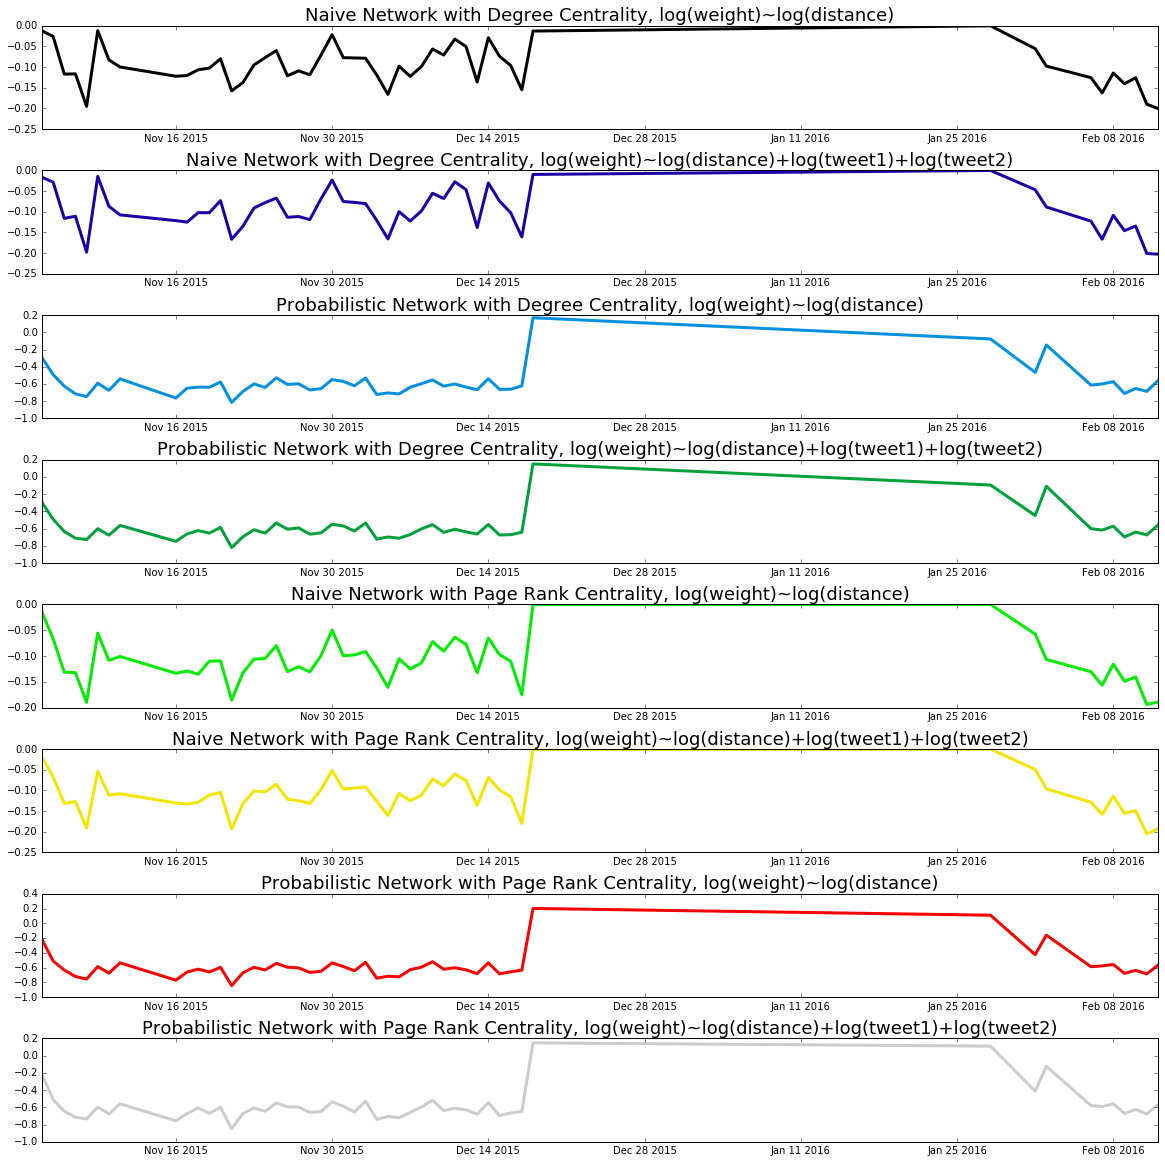

In [5]:
ExponentPlot()

In [6]:
def Dist_Centr_Comp(dataset, city_ziplist = PLACES, ziplist = USzipcode):
#     net = [(i,j) for i in PLACES for j in PLACES]
#     network = pd.DataFrame(net,copy = True, columns = ['zip1','zip2'])
#     ziplist = ziplist[ziplist.ZipCode.isin(city_ziplist)]
#     #each zipcode will be mapped into its coordinates for distance calculation
#     zipdict = {int(ziplist.iloc[i,0]):(ziplist.iloc[i,1],ziplist.iloc[i,2]) for i in range(len(ziplist))}
#     distance = [vincenty(zipdict[network.zip1[i]], zipdict[network.zip2[i]]).miles for i in range(len(net))]
    network = dataset.iloc[:,:4]
    network['DistRank'] = (stat.rankdata(network.distance, 'min')-1)*100/len(network)
    return network

In [44]:
def KLBin_init(dataset,bins=100):
    len1 = len(dataset)
    len2 = len(PLACES)
    #len2 = len(PLACES)
    K_label = ['K%d'%i for i in PLACES]
    L_label = ['L%d'%i for i in PLACES]
    bin_label = ['bin%d'%i for i in range(bins)]
    #bin_rank = (stat.rankdata(dataset.distance, 'min')-1)*bins/len1
    K = np.matrix(dataset.zip1).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
    K = pd.DataFrame(K*1, columns = K_label)
    L = np.matrix(dataset.zip2).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
    L = pd.DataFrame(L*1, columns = L_label)
    Bin = np.matrix(dataset.DistRank).T * np.matrix(np.ones((1,bins))) == np.matrix(np.ones(len1)).T * np.matrix(range(bins))
    Bin = pd.DataFrame(Bin*1, columns = bin_label)
    data = pd.concat([dataset, K, L, Bin], axis = 1)
    data.fillna(0, inplace = True)
    #data['Intercept'] = [1]*len1
    return data

In [43]:
Ridge=linear_model.Ridge()

## Ridge method, naive weights

In [49]:
naive = pd.read_csv(RootPath+'/GravModel/Overall/Net1/Net1Degree All days.csv', index_col=0)
naive = Dist_Centr_Comp(naive)
fit_naive = KLBin_init(naive)

random.seed(2016)
ix1 = stat.bernoulli.rvs(p = 0.67, size = len(fit_naive))
train1 = fit_naive.loc[ix1 == 1]
test1 = fit_naive.loc[ix1 == 0]

Y_train1 = log(train1.weight)
X_train1 = train1.iloc[:,5:]
Y_test1 = log(test1.weight)
X_test1 = test1.iloc[:,5:]

Ridge.fit(X_train1,Y_train1)
# In the sample:
p_IS=Ridge.predict(X_train1)
err_IS=p_IS-Y_train1
R_2_IS_Ridge=1-np.var(err_IS)/np.var(Y_train1)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_IS_Ridge))

#Out of sample
p_OS=Ridge.predict(X_test1)
err_OS=p_OS-Y_test1
R_2_OS_Ridge=1-np.var(err_OS)/np.var(Y_test1)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for In Sample Ridge is: 0.874221713092
The R-squared we found for Out of Sample Ridge is: 0.866831563699


## Ridge method, probabilistic weights

In [50]:
prob = pd.read_csv(RootPath+'/GravModel/Overall/Net2/Net2Degree All days.csv', index_col=0)
prob = prob[prob.weight != 0]
prob.index = range(len(prob))
prob = Dist_Centr_Comp(prob)
fit_prob = KLBin_init(prob)

random.seed(2016)
ix2 = stat.bernoulli.rvs(p = 0.67, size = len(fit_prob))
train2 = fit_prob.loc[ix2 == 1]
test2 = fit_prob.loc[ix2 == 0]

Y_train2 = log(train2.weight)
X_train2 = train2.iloc[:,5:]
Y_test2 = log(test2.weight)
X_test2 = test2.iloc[:,5:]

Ridge.fit(X_train2,Y_train2)
# In the sample:
p_IS=Ridge.predict(X_train2)
err_IS=p_IS-Y_train2
R_2_IS_Ridge=1-np.var(err_IS)/np.var(Y_train2)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_IS_Ridge))

#Out of sample
p_OS=Ridge.predict(X_test2)
err_OS=p_OS-Y_test2
R_2_OS_Ridge=1-np.var(err_OS)/np.var(Y_test2)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for In Sample Ridge is: 0.793130286391
The R-squared we found for Out of Sample Ridge is: 0.780860357792


In [47]:
Lasso = linear_model.Lasso()

## Lasso method, naive weights

In [51]:
Lasso.fit(X_train1,Y_train1)
# In the sample:
p_IS=Lasso.predict(X_train1)
err_IS=p_IS-Y_train1
R_2_IS_Lasso=1-np.var(err_IS)/np.var(Y_train1)
print('The R-squared we found for In Sample Lasso is: {0}'.format(R_2_IS_Lasso))

#Out of sample
p_OS=Lasso.predict(X_test1)
err_OS=p_OS-Y_test1
R_2_OS_Lasso=1-np.var(err_OS)/np.var(Y_test1)
print("The R-squared we found for Out of Sample Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for In Sample Lasso is: -6.39488462184e-14
The R-squared we found for Out of Sample Lasso is: 2.6645352591e-15


## Lasso method, probabilistic weights

In [52]:
Lasso.fit(X_train2,Y_train2)
# In the sample:
p_IS=Lasso.predict(X_train2)
err_IS=p_IS-Y_train2
R_2_IS_Lasso=1-np.var(err_IS)/np.var(Y_train2)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_IS_Lasso))

#Out of sample
p_OS=Lasso.predict(X_test2)
err_OS=p_OS-Y_test2
R_2_OS_Lasso=1-np.var(err_OS)/np.var(Y_test2)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OS_Lasso))

The R-squared we found for In Sample Ridge is: 6.88338275268e-15
The R-squared we found for Out of Sample Ridge is: 2.6645352591e-15


In [77]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_lambda(model,X_train,y_train,lambdas,p=0.3,Graph=False, logl=False):
    '''
    model=1 -Ridge, 2-Lasso
    X_train, y_train is training set
    lambdas: a list of lambda values to try
    p: ratio of the validation sample size/ total training size
    Graph: plot the graph of R^2 values for different lambda
    '''
    
    m = len(X_train)
    random.seed(2016)
    R_2_OS=[] #make a list to store R-squared. We need in end to pick the lambda having the biggest R2.
    
    validation_index = list( np.random.choice(range(m),size = int(m*p), replace = False))
    #choose some rows for the validation sample    
    training_index=[x for x in list(range(len(X_train))) if x not in validation_index]     
    
    X_validation=X_train.iloc[validation_index,:]
    y_validation=y_train.iloc[validation_index]

    X_train0=X_train.iloc[training_index,:]
    y_train0=y_train.iloc[training_index]
    
    
    for a in lambdas:
        if model==1:
            RM=linear_model.Ridge(fit_intercept=True, alpha=a)
            model_label='Ridge'
        else:
            RM=linear_model.Lasso(fit_intercept=True, alpha=a)
            model_label='Lasso'
        RM.fit(X_train0,y_train0)  #fit the regularization model
        
        y_predict=RM.predict(X_validation) #compute the prediction for the validation sample 
        err_OS=y_predict-y_validation
        R_2_OS_=1-np.var(err_OS)/np.var(y_validation)
        R_2_OS.append(R_2_OS_)
    
#Find the alpha that c.r.t the biggest R^2
    best_R2 = max(R_2_OS)
    for i in range(len(R_2_OS)):
        if R_2_OS[i]==best_R2:
            best_lambda=lambdas[i]
    #print("The alpha we found for Ridge is:{0}".format(l))
    
    #Graph
    if Graph==True:
        pylab.title('IS R-squared vs OS-R-squared for different Lambda')
        if logl:
            pylab.xlabel('ln(Lambda)')
            l=log(lambdas)
            bl=log(best_lambda)
        else:
            pylab.xlabel('Lambda')
            l=lambdas
            bl=best_lambda
        pylab.plot(l,R_2_OS,'b',label=model_label)
        pylab.legend(loc='upper right')
        pylab.ylabel('R-squared')
        pylab.axvline(bl,color='r',linestyle='--')

        pylab.show()
    
    return best_lambda

In [88]:
#select best lambda for Ridge
lambdas = np.linspace(-5,13,200)
lambdas=[math.exp(i) for i in lambdas]

In [89]:
RN_optimal = Regularization_fit_lambda(1,X_train1,Y_train1,lambdas)
print('Optimal lambda for Ridge={0}'.format(RN_optimal))

Optimal lambda for Ridge=0.00673794699909


In [90]:
RN = linear_model.Ridge(alpha = RN_optimal)
RN.fit(X_train1,Y_train1)
# In the sample:
p_ISRN = RN.predict(X_train1)
err_ISRN = p_ISRN - Y_train1
R_2_ISRN = 1-np.var(err_ISRN)/np.var(Y_train1)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_ISRN))

RN_coef = RN.coef_

#Out of sample
p_OSRN = RN.predict(X_test1)
err_OSRN = p_OSRN - Y_test1
R_2_OSRN = 1-np.var(err_OSRN)/np.var(Y_test1)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OSRN))

The R-squared we found for In Sample Ridge is: 0.874824028686
The R-squared we found for Out of Sample Ridge is: 0.868008309151


In [91]:
RP_optimal = Regularization_fit_lambda(1,X_train2,Y_train2,lambdas)
print('Optimal lambda for Ridge={0}'.format(RP_optimal))

Optimal lambda for Ridge=0.0848104355167


In [92]:
RP = linear_model.Ridge(alpha = RP_optimal)
RP.fit(X_train2,Y_train2)
# In the sample:
p_ISRP = RP.predict(X_train2)
err_ISRP = p_ISRP - Y_train2
R_2_ISRP=1-np.var(err_ISRP)/np.var(Y_train2)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_ISRP))

RP_coef = RP.coef_

#Out of sample
p_OSRP = RP.predict(X_test2)
err_OSRP = p_OSRP - Y_test2
R_2_OSRP = 1-np.var(err_OSRP)/np.var(Y_test2)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OSRP))

The R-squared we found for In Sample Ridge is: 0.793516806771
The R-squared we found for Out of Sample Ridge is: 0.781041792407


## NOTE: Changing alpha from 1 to the optimal value does not improve much for Ridge method, both with naive weights and prob weights
## Next let's check Lasso method

### Naive weights

In [93]:
LN_optimal = Regularization_fit_lambda(2,X_train1,Y_train1,lambdas)
print('Optimal lambda for Lasso = {0}'.format(LN_optimal))

Optimal lambda for Lasso = 0.00673794699909


In [95]:
LN = linear_model.Lasso(alpha = LN_optimal)
LN.fit(X_train1,Y_train1)
# In the sample:
p_ISLN=LN.predict(X_train1)
err_ISLN=p_ISLN-Y_train1
R_2_ISLN=1-np.var(err_ISLN)/np.var(Y_train1)
print('The R-squared we found for In Sample LN is: {0}'.format(R_2_ISLN))
LN_coef=LN.coef_

#Out of sample
p_OS=LN.predict(X_test1)
err_OS=p_OS-Y_test1
R_2_OSLN=1-np.var(err_OS)/np.var(Y_test1)
print("The R-squared we found for Out of Sample LN is: {0}".format(R_2_OSLN))

The R-squared we found for In Sample LN is: 0.112855734287
The R-squared we found for Out of Sample LN is: 0.11200643842


### Prob weights

In [96]:
LP_optimal = Regularization_fit_lambda(2,X_train2,Y_train2,lambdas)
print('Optimal lambda for Lasso = {0}'.format(LP_optimal))

Optimal lambda for Lasso = 0.00673794699909


In [97]:
LP = linear_model.Lasso(alpha = LP_optimal)
LP.fit(X_train2,Y_train2)
# In the sample:
p_ISLP = LP.predict(X_train2)
err_ISLP = p_ISLP - Y_train2
R_2_ISLP = 1-np.var(err_ISLP)/np.var(Y_train2)
print('The R-squared we found for In Sample Ridge is: {0}'.format(R_2_ISLP))
LP_coef = LP.coef_

#Out of sample
p_OSLP = LP.predict(X_test2)
err_OSLP = p_OSLP - Y_test2
R_2_OSLP = 1-np.var(err_OSLP)/np.var(Y_test2)
print("The R-squared we found for Out of Sample Ridge is: {0}".format(R_2_OSLP))

The R-squared we found for In Sample Ridge is: 0.303060173509
The R-squared we found for Out of Sample Ridge is: 0.29597596304


## So for Lasso method, changing $\lambda$ does significantly improve our $R^2$, and in both cases, $\lambda$ are really small

## Summary of $R^2$

In [140]:
data_summary = [(R_2_ISRN, R_2_OSRN, R_2_ISRP, R_2_OSRP), (R_2_ISLN, R_2_OSLN, R_2_ISLP, R_2_OSLP)]
arrays = [['Naive weights','Naive weights','Probabilistic weights','Probabilistic weights'],['In Sample',
                                                        'Out of Sample','In Sample','Out of Sample']]
tuples = list(zip(*arrays))
column = pd.MultiIndex.from_tuples(tuples)
pd.DataFrame(data_summary, columns = column, index = ['Ridge','Lasso'])

Naive weights               Probabilistic weights              
          In Sample Out of Sample             In Sample Out of Sample
Ridge      0.874824      0.868008              0.793517      0.781042
Lasso      0.112856      0.112006              0.303060      0.295976

## Next we plot $\log(f)$, the coefficient w.r.t the distance, on each bin/interval. The sub-intervals are sliced based on percentile so first interval contains all the distances lower than 1% of all data.

In [117]:
y1 = RN_coef[-100:]
y2 = RP_coef[-100:]
y3 = LN_coef[-100:]
y4 = LP_coef[-100:]

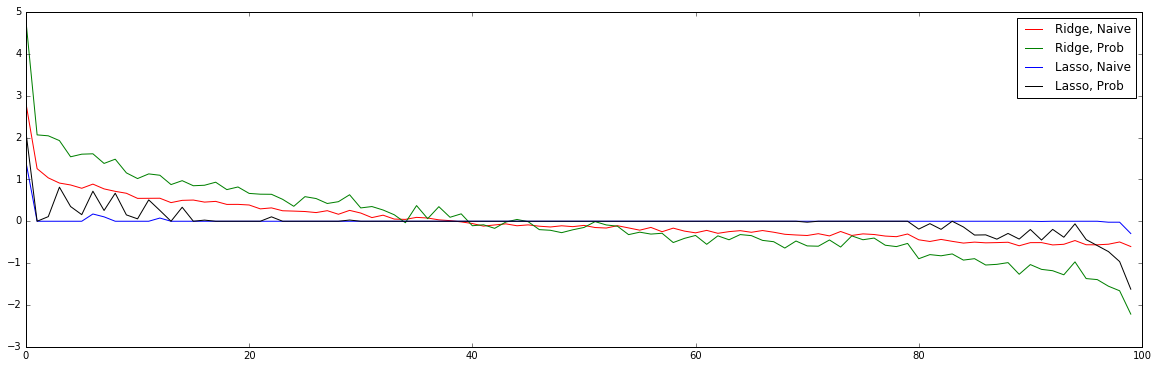

In [124]:
plt.figure(figsize=(20,6))
plt.plot(range(100),y1,'r')
plt.plot(range(100),y2,'g')
plt.plot(range(100),y3,'b')
plt.plot(range(100),y4,'k')
L = [i+j for i in ['Ridge, ','Lasso, '] for j in ['Naive','Prob']]
plt.legend(L)

# Appendix: the distribution of the distance

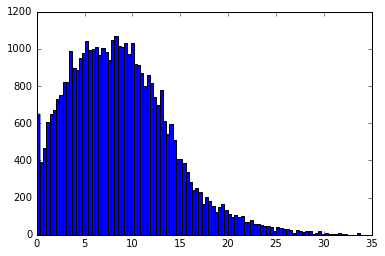

In [147]:
dist_hist = plt.hist(naive.distance, bins = 100)